In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading the dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


Preparing the data

In [3]:
import os
import random
import torch
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from PIL import Image

def prepare_data(root_dir,
                 batch_size=32,
                 img_size=(224, 224),
                 val_frac=0.1,
                 num_workers=None,
                 seed=42,
                 use_weighted_sampler=False,
                 pin_memory=True):
    """
    Prepare DataLoaders for train / val / test using torchvision.datasets.ImageFolder.
    - root_dir is expected to contain 'train' and 'test' subfolders. If 'val' exists it will be used,
      otherwise a stratified split from 'train' will be created.
    - Converts images to RGB (3-channels) for pretrained models.
    """
    if num_workers is None:
        num_workers = min(8, (os.cpu_count() or 4))

    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Basic transforms
    train_transform = transforms.Compose([
        # ensure 3 channels (pretrained nets expect 3-channel inputs)
        transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else img),
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),        # small rotations only
        transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else img),
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_dir = os.path.join(root_dir, 'train')
    val_dir = os.path.join(root_dir, 'val')
    test_dir = os.path.join(root_dir, 'test')

    # Load train dataset (ImageFolder expects structure train/<class>/*.jpeg)
    if not os.path.isdir(train_dir):
        raise FileNotFoundError(f"Train directory not found: {train_dir}")

    full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

    # If a separate val folder exists, use it. Otherwise create stratified split from train.
    if os.path.isdir(val_dir):
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
        train_dataset = full_train_dataset  # will keep training transform
        print("Found 'val' folder, using existing train/val/test folders.")
    else:
        # Stratified split using targets from ImageFolder
        targets = np.array(full_train_dataset.targets)
        indices = np.arange(len(full_train_dataset))
        train_idx, val_idx = train_test_split(indices,
                                              test_size=val_frac,
                                              stratify=targets,
                                              random_state=seed)
        train_dataset = Subset(full_train_dataset, train_idx)
        # Create a separate dataset instance for val with val transforms:
        # We re-create ImageFolder for val but override transform by mapping subset indices.
        val_base = datasets.ImageFolder(root=train_dir, transform=val_test_transform)
        val_dataset = Subset(val_base, val_idx)
        print(f"No 'val' dir found — created stratified val split: {len(train_idx)} train / {len(val_idx)} val")

    # Test dataset (required)
    if not os.path.isdir(test_dir):
        # if test folder missing, warn but continue (you may want to create one)
        print("Warning: 'test' folder not found. You should provide a test set for final evaluation.")
        test_dataset = None
        test_loader = None
    else:
        test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

    # Optionally create WeightedRandomSampler to mitigate class imbalance in training
    train_loader_kwargs = dict(batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    if use_weighted_sampler:
        # compute weights per sample for the train_dataset
        # If train_dataset is a Subset, get indices -> targets via underlying dataset
        if isinstance(train_dataset, Subset):
            underlying = full_train_dataset
            train_targets = np.array(underlying.targets)[train_dataset.indices]
        else:
            train_targets = np.array(train_dataset.dataset.targets) if isinstance(train_dataset, Subset) else np.array(train_dataset.targets)

        class_sample_count = np.array([np.sum(train_targets == t) for t in np.unique(train_targets)])
        # weight for each class = 1 / count
        weight_per_class = 1.0 / class_sample_count
        sample_weights = weight_per_class[train_targets]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                                  num_workers=num_workers, pin_memory=pin_memory)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=pin_memory)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)

    test_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers, pin_memory=pin_memory)

    # Print counts for sanity check
    def count_samples(ds):
        if ds is None:
            return "None"
        if isinstance(ds, Subset):
            # mapping to underlying ImageFolder to get class names
            base = ds.dataset
            targets = np.array(base.targets)[ds.indices]
            c = Counter(targets.tolist())
            # map numeric label -> class name
            label_to_name = {i: name for i, name in enumerate(base.classes)}
            return {label_to_name[k]: v for k, v in c.items()}
        else:
            if hasattr(ds, "targets"):
                c = Counter(ds.targets)
                return {ds.classes[k]: v for k, v in c.items()}
            elif hasattr(ds, "dataset") and hasattr(ds.dataset, "targets"):
                c = Counter(ds.dataset.targets)
                return {ds.dataset.classes[k]: v for k, v in c.items()}
            else:
                return "unknown"

    print("Dataset sizes (per-class):")
    print("Train:", count_samples(train_dataset))
    print("Val:  ", count_samples(val_dataset))
    print("Test: ", count_samples(test_dataset) if test_dataset is not None else "None")

    # return loaders and dataset metadata
    class_names = (full_train_dataset.classes if hasattr(full_train_dataset, "classes") else None)
    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "class_names": class_names
    }


In [4]:
# Prepare Data and Inspect Counts

root_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"   # adjust if different

data = prepare_data(
    root_dir=root_dir,
    batch_size=32,
    val_frac=0.10,           # only used if no val folder exists
    use_weighted_sampler=False,
    seed=42
)

train_loader   = data["train_loader"]
val_loader     = data["val_loader"]
test_loader    = data["test_loader"]
class_names    = data["class_names"]

print("\nClass Names:", class_names)
print("Number of Training Batches :", len(train_loader))
print("Number of Validation Batches:", len(val_loader))
print("Number of Test Batches     :", len(test_loader) if test_loader else "None")


Found 'val' folder, using existing train/val/test folders.
Dataset sizes (per-class):
Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val:   {'NORMAL': 8, 'PNEUMONIA': 8}
Test:  {'NORMAL': 234, 'PNEUMONIA': 390}

Class Names: ['NORMAL', 'PNEUMONIA']
Number of Training Batches : 163
Number of Validation Batches: 1
Number of Test Batches     : 20


Visualize Sample Images (original, not augmented)

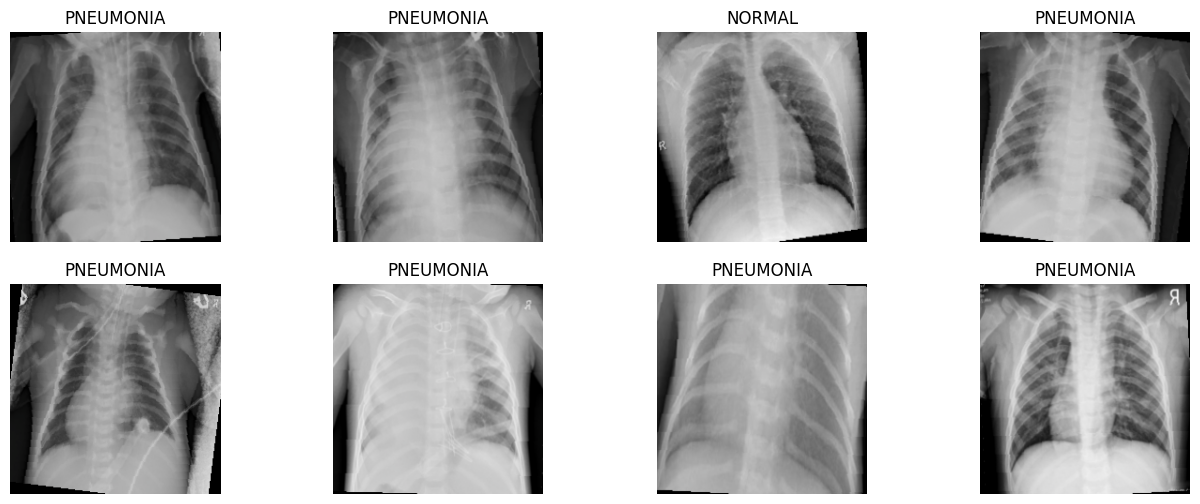

In [5]:
# Show Sample Images from the Dataset

import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_images_from_loader(loader, class_names, num_images=8):
    images, labels = next(iter(loader))

    plt.figure(figsize=(16, 6))
    for i in range(num_images):
        img = images[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + \
              np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])
        plt.axis("off")

    plt.show()

show_images_from_loader(train_loader, class_names)


Visualize AUGMENTED Images

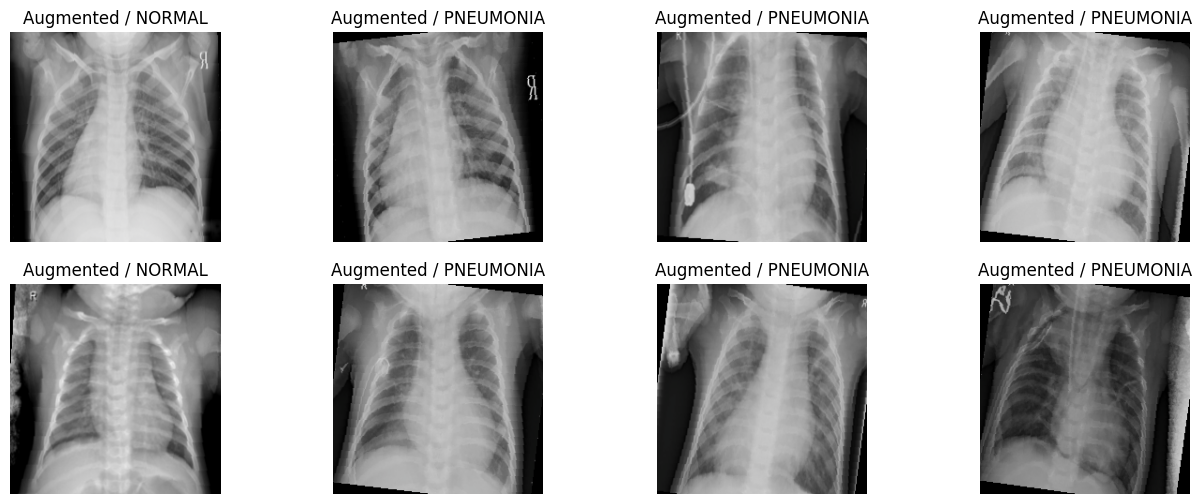

In [6]:
# Visualize AUGMENTED Training Images

from torchvision.utils import make_grid

def show_augmented_images(dataset, num_images=8):
    plt.figure(figsize=(16, 6))

    for i in range(num_images):
        img, label = dataset[np.random.randint(len(dataset))]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + \
              np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        plt.title(f"Augmented / {class_names[label]}")
        plt.axis("off")

    plt.show()

# If you used Subset for train_dataset:
if hasattr(data["train_dataset"], "dataset"):
    show_augmented_images(data["train_dataset"].dataset)
else:
    show_augmented_images(data["train_dataset"])



>>> Class: NORMAL — showing 5 images


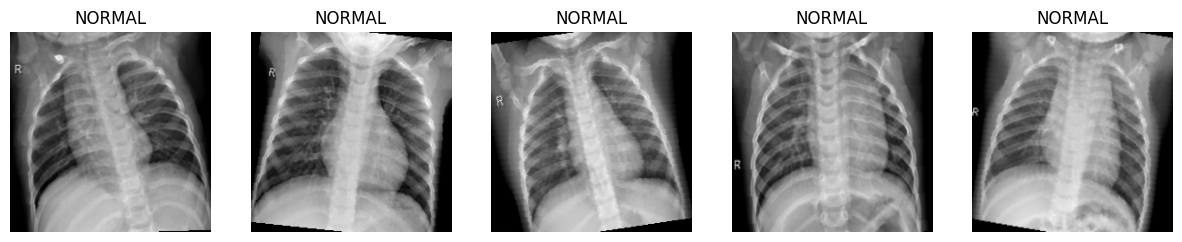


>>> Class: PNEUMONIA — showing 5 images


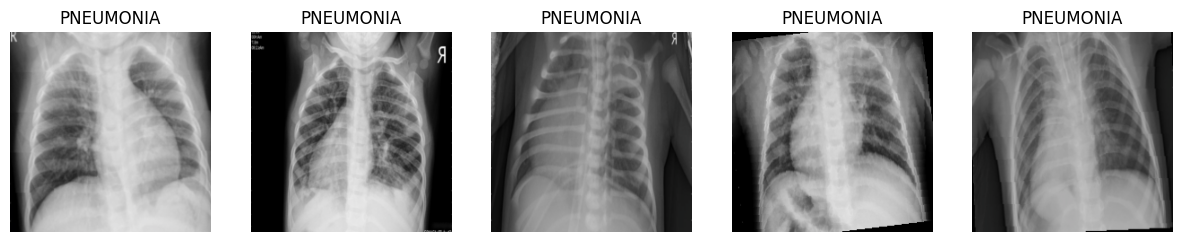

In [7]:
# Show 5 random images from each class

import random
import matplotlib.pyplot as plt
import numpy as np

def show_random_images_per_class(dataset, class_names, images_per_class=5):
    """
    Displays random images_per_class images for each class.
    Works even if dataset is a Subset.
    """

    # Handle Subset → get underlying dataset + index mapping
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = list(range(len(dataset)))

    # Map class → list of sample indices
    class_to_indices = {i: [] for i in range(len(class_names))}

    for idx in indices:
        _, label = base_dataset[idx]
        class_to_indices[label].append(idx)

    # Plot images
    for class_id, img_indices in class_to_indices.items():
        chosen = random.sample(img_indices, min(images_per_class, len(img_indices)))
        class_name = class_names[class_id]

        print(f"\n>>> Class: {class_name} — showing {len(chosen)} images")

        plt.figure(figsize=(15, 3))

        for i, idx in enumerate(chosen):
            img, _ = base_dataset[idx]

            # unnormalize for display
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            plt.subplot(1, images_per_class, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

        plt.show()

# Run it:
show_random_images_per_class(data["train_dataset"], class_names)


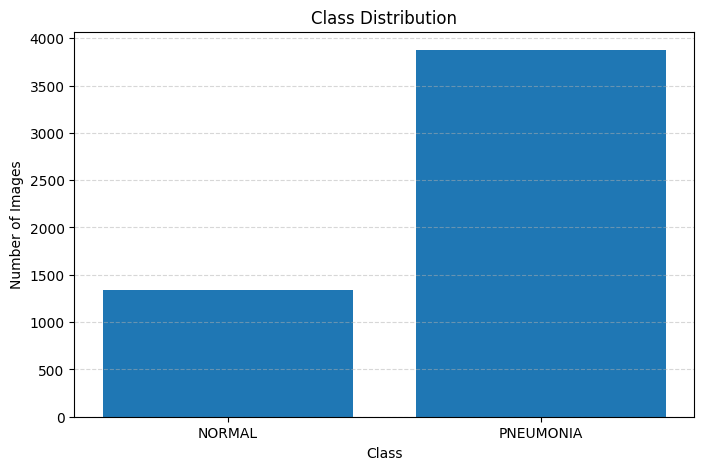

Class Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [8]:
# Visualize class imbalance ===

import matplotlib.pyplot as plt
from collections import Counter

def visualize_class_distribution(dataset, class_names):
    """
    Creates a bar chart of number of images per class.
    Works with Subset or full ImageFolder.
    """

    if isinstance(dataset, torch.utils.data.Subset):
        base = dataset.dataset
        targets = np.array(base.targets)[dataset.indices]
    else:
        targets = np.array(dataset.targets)

    counts = Counter(targets)
    labels = [class_names[i] for i in counts.keys()]
    values = [counts[i] for i in counts.keys()]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print("Class Counts:", {labels[i]: values[i] for i in range(len(labels))})

# Run on training dataset:
visualize_class_distribution(data["train_dataset"], class_names)


Rebuild train/val split (15% validation)

In [9]:
!pip install split-folders

import splitfolders
import os
import shutil

# Path to your original dataset
DATASET_PATH = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# New clean split output folder
OUTPUT_PATH = "/kaggle/working/data_new"

# --- Step 1: merge old train + val into one folder ---
MERGED_TRAIN = "/kaggle/working/merged_train"

if os.path.exists(MERGED_TRAIN):
    shutil.rmtree(MERGED_TRAIN)

os.makedirs(MERGED_TRAIN, exist_ok=True)

for subset in ["train", "val"]:
    subset_path = os.path.join(DATASET_PATH, subset)
    for cls in os.listdir(subset_path):
        cls_path = os.path.join(subset_path, cls)
        merged_cls_dir = os.path.join(MERGED_TRAIN, cls)
        os.makedirs(merged_cls_dir, exist_ok=True)

        for img in os.listdir(cls_path):
            src = os.path.join(cls_path, img)
            dst = os.path.join(merged_cls_dir, img)
            shutil.copy(src, dst)

print("Merged TRAIN + VAL into:", MERGED_TRAIN)

# --- Step 2: split merged_train into new train/val ---
splitfolders.ratio(
    MERGED_TRAIN,
    output=OUTPUT_PATH,
    seed=42,
    ratio=(0.85, 0.15),   # 85% train / 15% val
)

# --- Step 3: Copy test folder ---
shutil.copytree(
    os.path.join(DATASET_PATH, "test"),
    os.path.join(OUTPUT_PATH, "test")
)

print("New dataset created at:", OUTPUT_PATH)


Merged TRAIN + VAL into: /kaggle/working/merged_train


Copying files: 5232 files [00:07, 719.75 files/s]


New dataset created at: /kaggle/working/data_new


Rebuild DataLoaders (Inception V1 compatible)

Inception V1 expects:

224 × 224 input

mean = [0.5, 0.5, 0.5]

std = [0.5, 0.5, 0.5]

Normalization in range [-1, +1]

In [10]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Inception V1 normalization
inception_mean = [0.5, 0.5, 0.5]
inception_std  = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(mean=inception_mean, std=inception_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=inception_mean, std=inception_std)
])

train_dir = "/kaggle/working/data_new/train"
val_dir   = "/kaggle/working/data_new/val"
test_dir  = "/kaggle/working/data_new/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

print("Classes:", train_dataset.classes)


Train samples: 4446
Val samples: 786
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


Compute Class Weights (for imbalance)

In [11]:
from collections import Counter
import torch

counts = Counter([label for _, label in train_dataset])
num_classes = len(counts)

class_weights = [1.0 / counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print("Class Counts:", counts)
print("Class Weights:", class_weights)


Class Counts: Counter({1: 3300, 0: 1146})
Class Weights: tensor([0.0009, 0.0003])



**Load Inception V1 (GoogLeNet) pretrainedPyTorch does not include Inception V1 directly under that name —GoogLeNet = Inception v1, and it is available with pretrained ImageNet weights.**


In [12]:
from torchvision import models
import torch.nn as nn
import torch

# Load pretrained GoogLeNet (Inception V1)
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

# Freeze all layers for transfer learning
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: NORMAL / PNEUMONIA

model = model.to("cuda")
print(model)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 121MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Add Class Weights to the Loss

Use the class weights we produced

In [13]:
class_weights = torch.tensor([0.0009, 0.0003]).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)


**Optimizer and Learning Rate Scheduler

Since layers are frozen, only the final FC layer learns → learning is stable → use a small LR.**

In [14]:
optimizer = torch.optim.AdamW(
    model.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1
)



Training & Validation Loop

Just the skeleton for now

In [15]:
def train_one_epoch(model, loader, criterion, optimizer, device="cuda"):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy


def evaluate(model, loader, criterion, device="cuda"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return total_loss / len(loader),accuracy


Training Loop (with scheduler)

Epoch [1/7] Train Loss: 0.3859 Train Acc: 0.8369 Val Loss: 0.2888 Val Acc: 0.8842
Epoch [2/7] Train Loss: 0.2408 Train Acc: 0.9087 Val Loss: 0.2880 Val Acc: 0.8639
Epoch [3/7] Train Loss: 0.2129 Train Acc: 0.9159 Val Loss: 0.1839 Val Acc: 0.9326
Epoch [4/7] Train Loss: 0.2071 Train Acc: 0.9136 Val Loss: 0.2602 Val Acc: 0.8868
Epoch [5/7] Train Loss: 0.2062 Train Acc: 0.9172 Val Loss: 0.1633 Val Acc: 0.9377
Epoch [6/7] Train Loss: 0.1813 Train Acc: 0.9285 Val Loss: 0.1699 Val Acc: 0.9300
Epoch [7/7] Train Loss: 0.1811 Train Acc: 0.9271 Val Loss: 0.1771 Val Acc: 0.9275


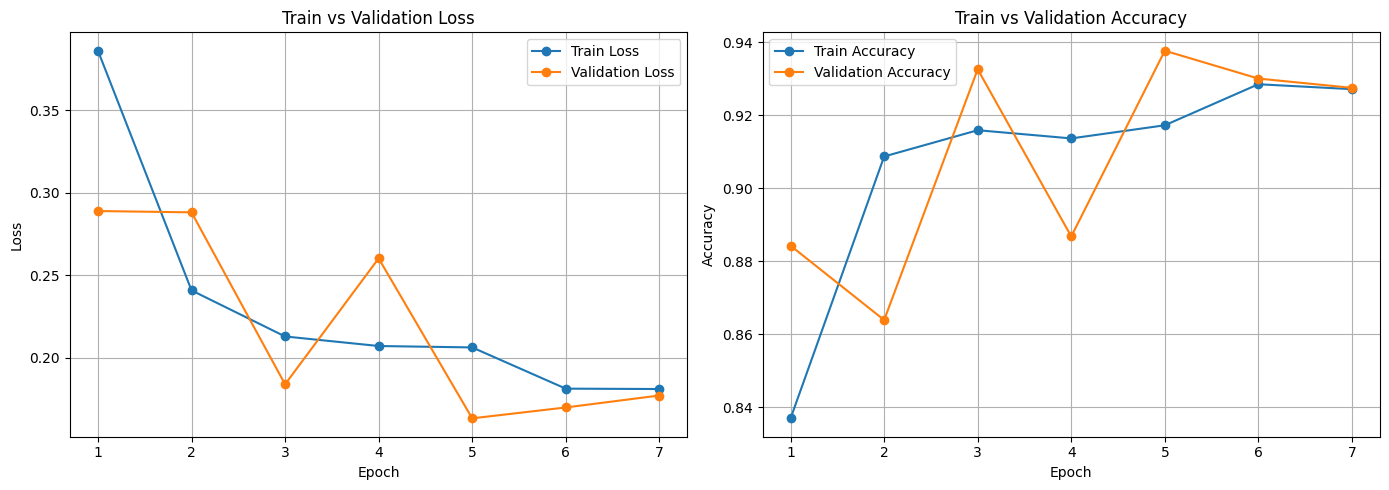

In [16]:
EPOCHS = 7
device = "cuda" if torch.cuda.is_available() else "cpu"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device=device)

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device=device)

    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Step scheduler
    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")

# ======== Plot Loss and Accuracy ========
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Generate Predictions on Test Set

In [17]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda"

def get_predictions(model, loader):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:,1]      # Probability of class "PNEUMONIA"
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


Compute Evaluation Metrics

In [18]:
y_true, y_pred, y_prob = get_predictions(model, test_loader)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("📌 Model Performance on Test Set")
print("--------------------------------")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")


📌 Model Performance on Test Set
--------------------------------
Accuracy  : 0.8910
Precision : 0.8852
Recall    : 0.9487
F1-Score  : 0.9158


Confusion Matrix

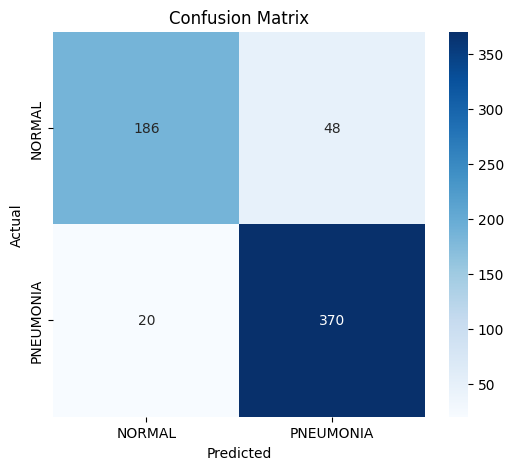

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


ROC Curve + AUC

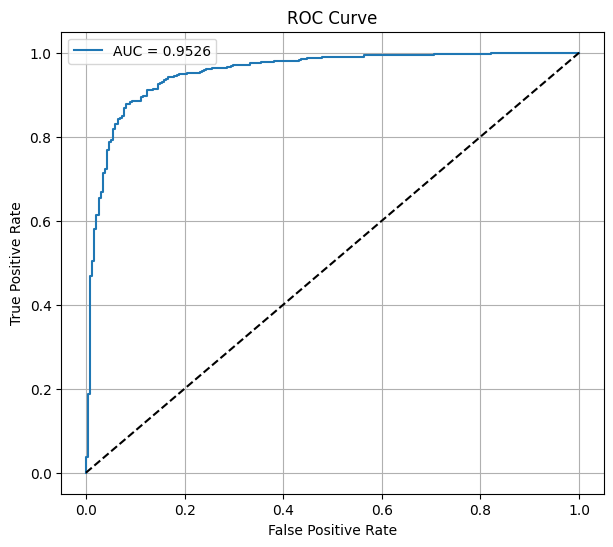

ROC AUC Score: 0.9526


In [20]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Visualize First Convolution Layer Filters (Inception V1)

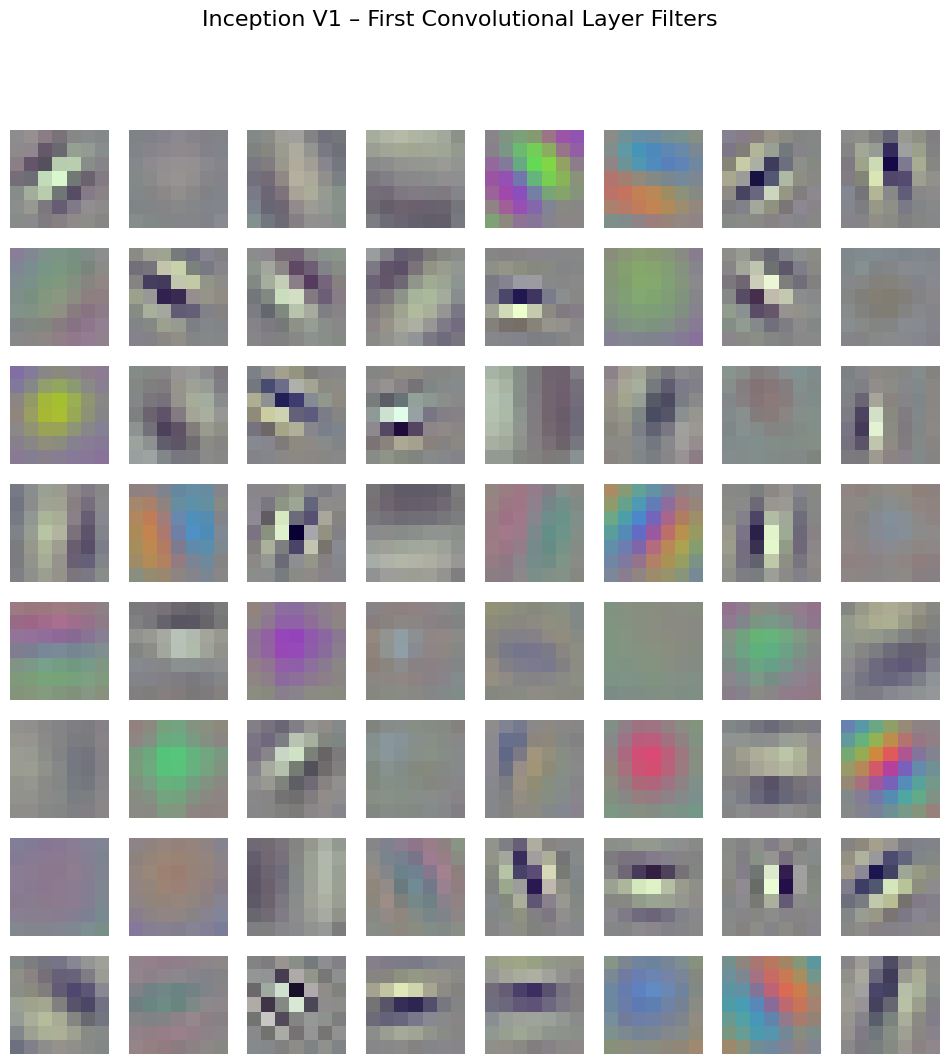

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get first conv layer of Inception V1
first_conv = model.conv1.conv.weight.data.cpu()

# Normalize filters to [0,1] for visualization
min_val = first_conv.min()
max_val = first_conv.max()
filters = (first_conv - min_val) / (max_val - min_val)

num_filters = filters.shape[0]

plt.figure(figsize=(12, 12))

for i in range(num_filters):
    plt.subplot(8, 8, i+1)  # 64 filters
    plt.imshow(filters[i].permute(1, 2, 0))  # C,H,W → H,W,C
    plt.axis('off')

plt.suptitle("Inception V1 – First Convolutional Layer Filters", fontsize=16)
plt.show()


Visualize Feature Maps (Activation Maps)

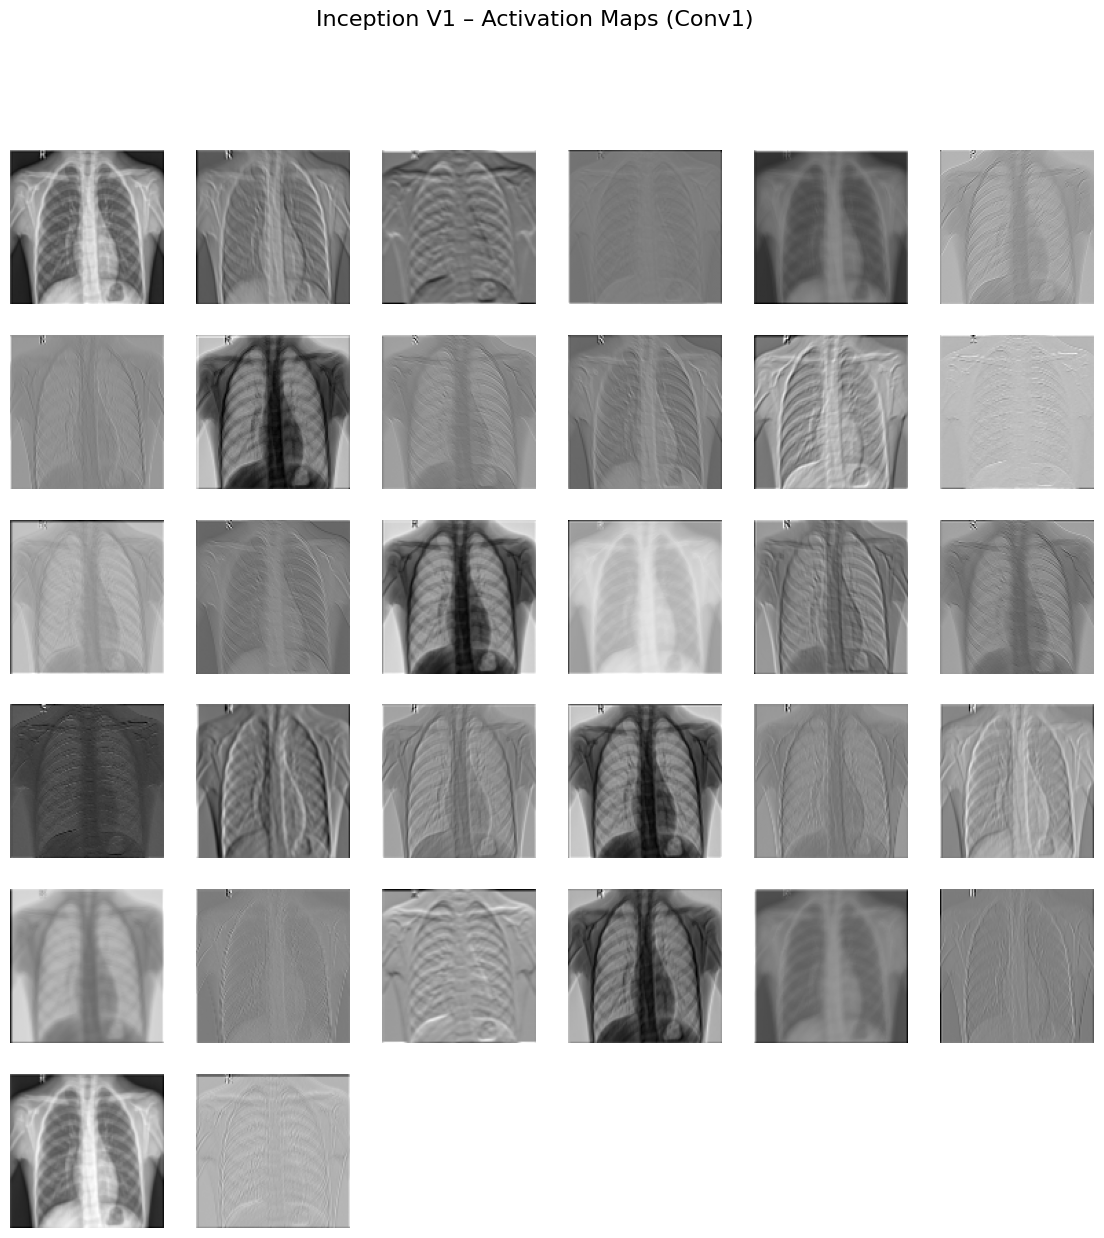

In [22]:
# Hook to capture activations
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

layer = model.conv1.conv
layer.register_forward_hook(get_activation('conv1'))

# Take one example image from test_loader
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to("cuda")

_ = model(image)  # forward pass

feature_maps = activation['conv1'].cpu().squeeze()

plt.figure(figsize=(14, 14))
for i in range(1, 33):  # show first 32 feature maps
    plt.subplot(6, 6, i)
    plt.imshow(feature_maps[i].numpy(), cmap='gray')
    plt.axis('off')

plt.suptitle("Inception V1 – Activation Maps (Conv1)", fontsize=16)
plt.show()


GRAD-CAM (Recommended for Medical Imaging)

In [23]:
# Allow gradients ONLY for last conv layer — safe for GradCAM
for param in model.inception5b.parameters():
    param.requires_grad = True




In [24]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def gradcam(model, image_tensor, target_layer):
    model.eval()

    # ----- STORAGE FOR ACTIVATIONS -----
    activations = {}

    # ----- FORWARD HOOK -----
    def forward_hook(module, inp, out):
        activations["value"] = out

    hook_handle = target_layer.register_forward_hook(forward_hook)

    # ----- FORWARD PASS -----
    output = model(image_tensor)

    # GoogLeNet may return (logits, aux_logits)
    if isinstance(output, (tuple, list)):
        logits = output[0]
    else:
        logits = output

    pred_class = logits.argmax(dim=1).item()
    score = logits[0, pred_class]

    # get activation tensor
    act = activations["value"]

    # ----- BACKWARD: GET GRADIENT OF SCORE W.R.T ACTIVATIONS -----
    grads = torch.autograd.grad(
        outputs=score,
        inputs=act,
        retain_graph=False
    )[0]

    # Remove hook
    hook_handle.remove()

    # ----- PROCESS GRADIENTS + ACTIVATIONS -----
    grads = grads[0].detach().cpu().numpy()
    act   = act[0].detach().cpu().numpy()

    # global average pooling over H,W
    weights = grads.mean(axis=(1, 2))

    # weighted sum
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    # ReLU
    cam = np.maximum(cam, 0)

    # Normalize
    cam = cv2.resize(cam, (224, 224))
    if cam.max() > 0:
        cam = cam / cam.max()

    return cam, pred_class


In [25]:
def visualize_gradcam(image_tensor, cam):
    # unnormalize
    img = image_tensor[0].permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] / 255.0  # BGR→RGB

    overlay = 0.4 * heatmap + img
    overlay = overlay / overlay.max()

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()


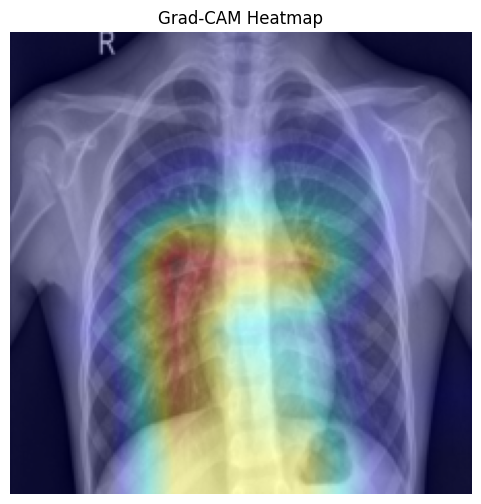

Predicted class: 0
True class: 0


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example batch
images, labels = next(iter(test_loader))

image = images[0].unsqueeze(0).to(device)

# Compute Grad-CAM
cam, pred_class = gradcam(model, image, model.inception5b)

# Visualize
visualize_gradcam(image, cam)

print("Predicted class:", pred_class)
print("True class:", labels[0].item())


save the model

In [27]:
torch.save(model.state_dict(), "/kaggle/working/inceptionv1_best.pth")

In [28]:
import shutil

# Specify the folder you want to zip
shutil.make_archive('/kaggle/working/data_backup', 'zip', '/kaggle/working/data_new')
shutil.make_archive('/kaggle/working/merged_train_backup', 'zip', '/kaggle/working/merged_train')


'/kaggle/working/merged_train_backup.zip'